In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

In [103]:
# Генератор синуса (гармонического сигнала)
A = np.random.randint(1, 11) # случайная амплитуда (от 1 до 10) [у.е.]
f = 0.5 # частота сигнала [Гц]
w = 2 * np.pi * f # циклическая частота сигнала [рад/с]
t_duration = 3 # длительность сигнала [с]

SR = 100 # частота дискретизации [выб/с]
SP = 1/SR # период дискретизации [с]
N = t_duration * SR # количество отсчетов сигнала [выб]
t = np.linspace(0, t_duration, N, endpoint=False) # временной диапазон [с]

signal = A * np.sin(w * t) # гармонический сигнал

In [104]:
# Интерполяция сигнала
K_up = 2 # коэффициент повышения частоты дискретизации сигнала
t_int = np.linspace(t[0], t_duration, int(K_up * N), endpoint=False) # временной диапазон интерполированного сигнала [с]

def linear_interpolation(signal, t, t_int): # кусочно-линейная интерполяция сигнала
    interLIN_func = interp1d(t, signal, kind='linear', bounds_error=False, fill_value="extrapolate")
    return interLIN_func(t_int)

def sinc_interpolation(signal, N, SP, t_int): # sinc-интерполяция сигнала
    interSINC_func = np.zeros_like(t_int) # предварительное распределение расчетов
    for i, ti in enumerate(t_int):
        n = np.arange(len(signal)) # количество отсчетов сигнала на входе интерполятора [выб]
        arg = (ti - n * SP) / SP # вычисляем аргумент sinc
        interSINC_func[i] = np.sum(signal * np.sinc(arg))
    return interSINC_func

interLIN_signal = linear_interpolation(signal, t, t_int)
interSINC_signal = sinc_interpolation(signal, N, SP, t_int)

N_L = len(interLIN_signal) # количество отсчетов интерполированного сигнала (лин.) [выб]
N_S = len(interSINC_signal) # количество отсчетов интерполированного сигнала (sinc) [выб]
SR_L = N_L/t_int[-1] # частота дискретизации интерполированного сигнала (лин.) [выб/с]
SR_S = N_S/t_int[-1] # частота дискретизации интерполированного сигнала (sinc) [выб/с]

In [105]:
# Децимация сигнала
K_down = 2 # коэффициент понижения частоты дискретизации сигнала

def ordinary_decimation(signal, K_down): # децимация путем исключения каждого K_down'го отсчета
    return signal[::K_down]

dec_signal = ordinary_decimation(signal, K_down)

t_dec = np.linspace(t[0], t_duration, len(dec_signal), endpoint=False) # временной диапазон прореженного сигнала [с]
N_dec = len(dec_signal) # количество отсчетов прореженного сигнала [выб]
SR_dec = N_dec/t_dec[-1] # частота дискретизации прореженного сигнала [выб/с]
SP_dec = 1/SR_dec # # период дискретизации прореженного сигнала [с]

In [106]:
# Интерполяция прореженного сигнала (генератор сигнала -> дециматор -> интерполятор -> выход)
t_d_int = np.linspace(t_dec[0], t_duration, K_up * len(dec_signal), endpoint=False) # временной диапазон сигнала на выходе интерполятора [с]

def lin_inter_of_dec(dec_signal, t_dec, t_d_int): # кусочно-линейная интерполяция сигнала
    interLIN_func = interp1d(t_dec, dec_signal, kind='linear', bounds_error=False, fill_value="extrapolate") 
    return interLIN_func(t_d_int)

def sinc_inter_of_dec(dec_signal, SP_dec, t_d_int): # sinc-интерполяция сигнала
    interSINC_func = np.zeros_like(t_d_int) # предварительное распределение расчетов
    for i, ti in enumerate(t_d_int):
        n = np.arange(len(dec_signal)) # количество отсчетов сигнала на входе интерполятора [выб] 
        arg = (ti - n * SP_dec) / SP_dec # вычисляем аргумент sinc
        interSINC_func[i] = np.sum(dec_signal * np.sinc(arg))
    return interSINC_func

outputL_signal = lin_inter_of_dec(dec_signal, t_dec, t_d_int)
outputS_signal = sinc_inter_of_dec(dec_signal, SP_dec, t_d_int)

N_outL = len(outputL_signal) # количество отсчетов выходного сигнала (лин.) [выб]
N_outS = len(outputS_signal) # количество отсчетов выходного сигнала (sinc) [выб]
SR_outL = N_outL/t_d_int[-1] # частота дискретизации выходного сигнала (лин.) [выб/с]
SR_outS = N_outS/t_d_int[-1] # частота дискретизации выходного сигнала (sinc) [выб/с]

errL = (abs(SR - SR_outL) / SR_outL) * 100 # относительная погрешность между входным и выходным сигналом (лин.) (в %)
errS = (abs(SR - SR_outS) / SR_outS) * 100 # относительная погрешность между входным и выходным сигналом (sinc) (в %)

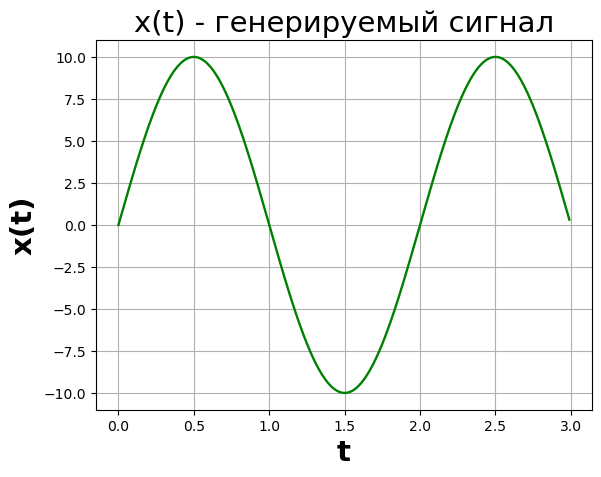

Генерируемый сигнал: N = 300 выб, SR = 100 выб/с


In [107]:
# Иллюстрация сигнала
plt.plot(t, signal, 'g-', linewidth=1.7)
plt.title('x(t) - генерируемый сигнал', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()
plt.show()

print(f'Генерируемый сигнал: N = {N} выб, SR = {SR} выб/с')

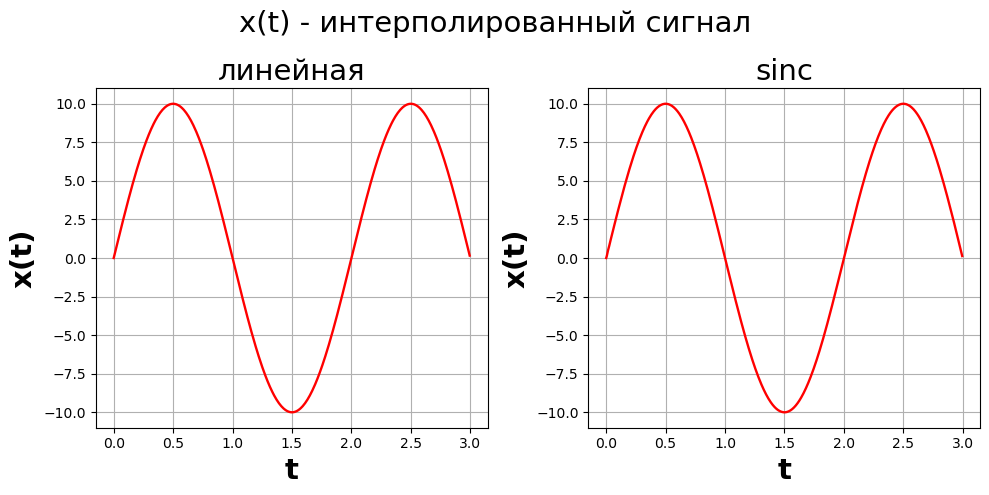

Сигнал (лин.интерполяция): N = 600 выб, SR = 200.3338898163606 выб/с
Сигнал (sinc-интерполяция): N = 600 выб, SR = 200.3338898163606 выб/с


In [108]:
# Иллюстрация сигнала (после интерполяции)
plt.figure(figsize=(10, 5))
plt.suptitle('x(t) - интерполированный сигнал', fontsize=21)
plt.subplot(1, 2, 1)
plt.plot(t_int, interLIN_signal, 'r-', linewidth=1.7)
plt.title('линейная', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t_int, interSINC_signal, 'r-', linewidth=1.7)
plt.title('sinc', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()

plt.tight_layout()
plt.show()

print(f'Сигнал (лин.интерполяция): N = {N_L} выб, SR = {SR_L} выб/с')
print(f'Сигнал (sinc-интерполяция): N = {N_S} выб, SR = {SR_S} выб/с')

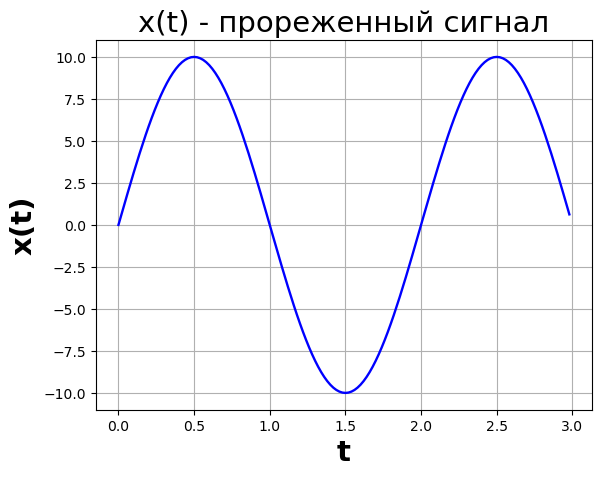

Сигнал (прореженный): N = 150 выб, SR = 50.33557046979866 выб/с


In [109]:
# Иллюстрация сигнала (после прореживания)
plt.plot(t_dec, dec_signal, 'b-', linewidth=1.7)
plt.title('x(t) - прореженный сигнал', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()
plt.show()

print(f'Сигнал (прореженный): N = {N_dec} выб, SR = {SR_dec} выб/с')

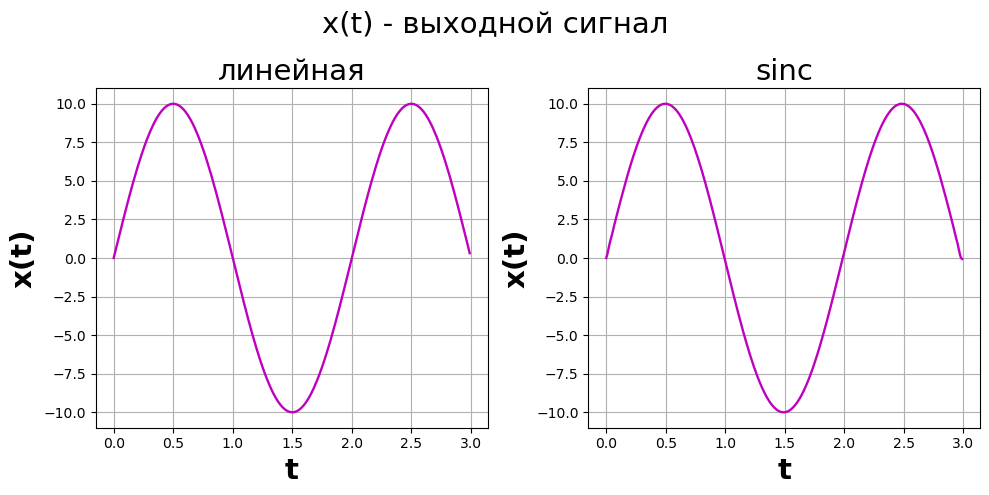

Сигнал на выходе (лин.): N = 300 выб, SR = 100.3344481605351 выб/с
Сигнал на выходе (sinc): N = 300 выб, SR = 100.3344481605351 выб/с
Относительная погрешность: 0.3333333333333199 % (лин.), 0.3333333333333199 % (sinc)


In [110]:
# Иллюстрация сигнала (генератор сигнала -> дециматор -> интерполятор -> выход)
plt.figure(figsize=(10, 5))
plt.suptitle('x(t) - выходной сигнал', fontsize=21)
plt.subplot(1, 2, 1)
plt.plot(t_d_int, outputL_signal, 'm-', linewidth=1.7)
plt.title('линейная', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(t_d_int, outputS_signal, 'm-', linewidth=1.7)
plt.title('sinc', fontsize=21)
plt.xlabel('t', fontsize=21, fontweight='bold')
plt.ylabel('x(t)', fontsize=21, fontweight='bold')
plt.grid()

plt.tight_layout()
plt.show()

print(f'Сигнал на выходе (лин.): N = {N_outL} выб, SR = {SR_outL} выб/с')
print(f'Сигнал на выходе (sinc): N = {N_outS} выб, SR = {SR_outS} выб/с')
print(f'Относительная погрешность: {errL} % (лин.), {errS} % (sinc)')